In [5]:
import pandas as pd

# ✅ Step 1: Load conditions dataset
conditions = pd.read_csv("conditions.csv")

# ✅ Step 2: Define comorbidities and their weights
condition_weights = {
    "Congestive Heart Failure": 0.30,
    "Chronic Kidney Disease": 0.25,
    "Chronic Obstructive Pulmonary Disease": 0.20,
    "Diabetes": 0.15,
    "Hypertension": 0.10,
    "Cancer": 0.40
}

# ✅ Step 3: Map conditions in the dataset
def map_comorbidity(desc):
    for condition in condition_weights.keys():
        if condition.lower() in desc.lower():
            return condition
    return None  # Ignore unrelated conditions

conditions["mapped_condition"] = conditions["DESCRIPTION"].map(map_comorbidity)
conditions_scored = conditions[conditions["mapped_condition"].notnull()]  # Keep only relevant conditions

# ✅ Step 4: Assign weights
conditions_scored["weight"] = conditions_scored["mapped_condition"].map(condition_weights)

# ✅ Step 5: Aggregate per patient
comorb_score = conditions_scored.groupby("PATIENT")["weight"].sum().reset_index()
comorb_score.rename(columns={"weight": "C_score"}, inplace=True)

# ✅ Step 6: Cap the score at 1.0 (so it doesn't dominate other factors)
comorb_score["C_score"] = comorb_score["C_score"].clip(upper=1.0)

# ✅ Step 7: Print Summary Stats
print("\n=== Summary Statistics for C_score ===")
print(comorb_score["C_score"].describe())

print("\n=== Unique Comorbidity Scores and Counts ===")
print(comorb_score["C_score"].value_counts())





=== Summary Statistics for C_score ===
count    53.00000
mean      0.30566
std       0.31572
min       0.10000
25%       0.10000
50%       0.15000
75%       0.25000
max       1.00000
Name: C_score, dtype: float64

=== Unique Comorbidity Scores and Counts ===
C_score
0.15    20
0.10    15
1.00     6
0.25     6
0.90     2
0.50     1
0.80     1
0.70     1
0.40     1
Name: count, dtype: int64


C:\Users\savas\AppData\Local\Temp\ipykernel_8008\4116165792.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conditions_scored["weight"] = conditions_scored["mapped_condition"].map(condition_weights)


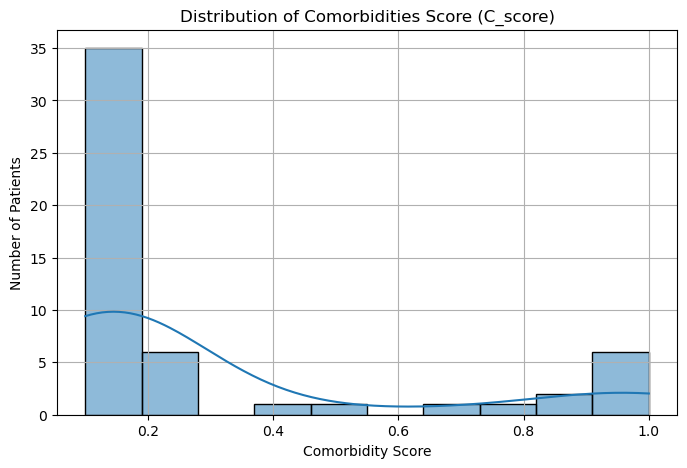

In [7]:
# ✅ Step 8: Plot Distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(comorb_score["C_score"], bins=10, kde=True, edgecolor="black")
plt.title("Distribution of Comorbidities Score (C_score)")
plt.xlabel("Comorbidity Score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()


=== Summary Statistics for M_score ===
count    14.000000
mean      0.464286
std       0.379994
min       0.150000
25%       0.150000
50%       0.300000
75%       0.925000
max       1.000000
Name: M_score, dtype: float64

=== Unique Medications & Procedures Scores and Counts ===
M_score
0.15    6
1.00    4
0.30    3
0.70    1
Name: count, dtype: int64


C:\Users\savas\AppData\Local\Temp\ipykernel_8008\2203994899.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_filtered["weight"] = meds_filtered["mapped_intervention"].map(intervention_weights)
C:\Users\savas\AppData\Local\Temp\ipykernel_8008\2203994899.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procs_filtered["weight"] = procs_filtered["mapped_intervention"].map(intervention_weights)


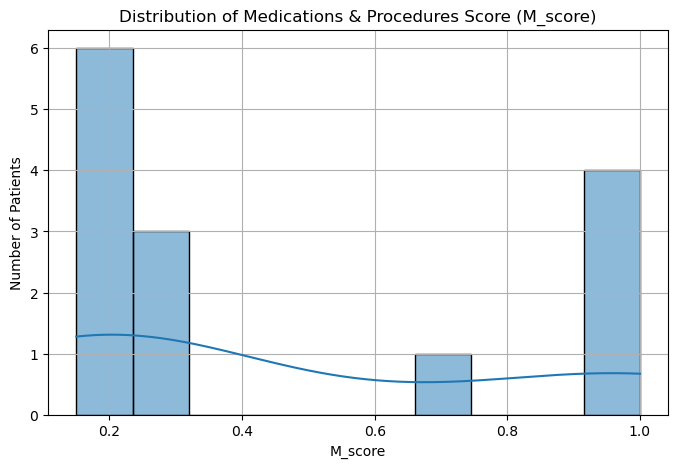

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Load datasets
meds = pd.read_csv("medications.csv")
procs = pd.read_csv("procedures.csv")

# ✅ Step 2: Define critical medications & procedures with weights
intervention_weights = {
    "Vasopressor": 0.30,  # High ICU risk (e.g., Norepinephrine)
    "Mechanical Ventilation": 0.30,  # Severe cases
    "Dialysis": 0.25,  # Kidney failure cases
    "Sedative": 0.20,  # Common in ICU patients
    "Antibiotic": 0.15  # Severe infections
}

# ✅ Step 3: Function to match descriptions to categories
def map_intervention(desc):
    desc = desc.lower()
    if "vasopressor" in desc or "norepinephrine" in desc or "dopamine" in desc:
        return "Vasopressor"
    elif "ventilation" in desc or "intubation" in desc:
        return "Mechanical Ventilation"
    elif "dialysis" in desc:
        return "Dialysis"
    elif "sedative" in desc or "propofol" in desc or "midazolam" in desc:
        return "Sedative"
    elif "antibiotic" in desc or "vancomycin" in desc or "meropenem" in desc:
        return "Antibiotic"
    return None  # Ignore unrelated meds/procedures

# ✅ Step 4: Apply mapping
meds["mapped_intervention"] = meds["DESCRIPTION"].map(map_intervention)
procs["mapped_intervention"] = procs["DESCRIPTION"].map(map_intervention)

# Keep only relevant interventions
meds_filtered = meds[meds["mapped_intervention"].notnull()]
procs_filtered = procs[procs["mapped_intervention"].notnull()]

# Assign weights
meds_filtered["weight"] = meds_filtered["mapped_intervention"].map(intervention_weights)
procs_filtered["weight"] = procs_filtered["mapped_intervention"].map(intervention_weights)

# ✅ Step 5: Merge medications and procedures data
intervention_df = pd.concat([meds_filtered[["PATIENT", "weight"]], procs_filtered[["PATIENT", "weight"]]])

# ✅ Step 6: Aggregate scores per patient
m_score = intervention_df.groupby("PATIENT")["weight"].sum().reset_index()
m_score.rename(columns={"weight": "M_score"}, inplace=True)

# ✅ Step 7: Cap at 1.0
m_score["M_score"] = m_score["M_score"].clip(upper=1.0)

# ✅ Step 8: Print Summary Stats
print("\n=== Summary Statistics for M_score ===")
print(m_score["M_score"].describe())

print("\n=== Unique Medications & Procedures Scores and Counts ===")
print(m_score["M_score"].value_counts())

# ✅ Step 9: Plot Distribution
plt.figure(figsize=(8, 5))
sns.histplot(m_score["M_score"], bins=10, kde=True, edgecolor="black")
plt.title("Distribution of Medications & Procedures Score (M_score)")
plt.xlabel("M_score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()



=== Summary Statistics for Refined M_score ===
count    21.000000
mean      0.143209
std       0.320750
min       0.000923
25%       0.000923
50%       0.001845
75%       0.011993
max       1.000000
Name: M_score, dtype: float64

=== Unique Medications & Procedures Scores and Counts ===
M_score
0.000923    8
0.001845    4
1.000000    1
0.010148    1
0.006458    1
0.987085    1
0.649446    1
0.302583    1
0.011993    1
0.011070    1
0.013838    1
Name: count, dtype: int64


C:\Users\savas\AppData\Local\Temp\ipykernel_8008\2981721338.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  meds_filtered["weight"] = meds_filtered["mapped_intervention"].map(intervention_weights)
C:\Users\savas\AppData\Local\Temp\ipykernel_8008\2981721338.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  procs_filtered["weight"] = procs_filtered["mapped_intervention"].map(intervention_weights)


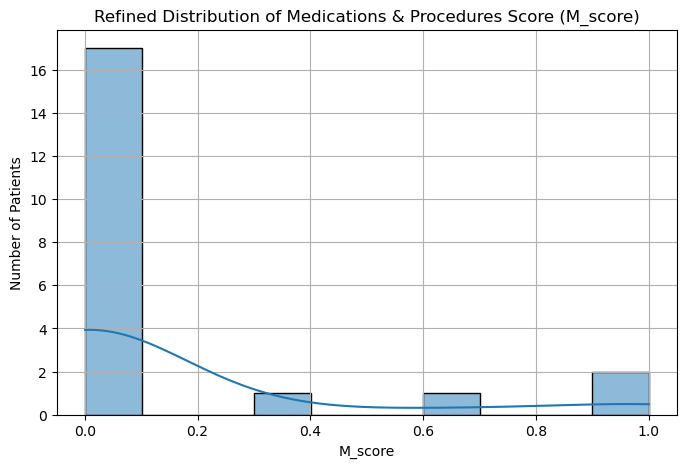

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Load datasets
meds = pd.read_csv("medications.csv")
procs = pd.read_csv("procedures.csv")

# ✅ Step 2: Define an expanded set of medications & procedures with refined weights
intervention_weights = {
    "Vasopressor": 0.25,  # Norepinephrine, Dopamine, etc.
    "Mechanical Ventilation": 0.25,  # Intubation, invasive ventilation
    "Dialysis": 0.20,  # Kidney failure cases
    "Sedative": 0.15,  # Propofol, Midazolam, general sedation
    "Antibiotic": 0.10,  # Broad-spectrum antibiotics (Vancomycin, Meropenem)
    "Steroid": 0.10,  # Dexamethasone, Hydrocortisone (often used in critical care)
    "Opioid": 0.10,  # Morphine, Fentanyl (sedation in ICU)
    "Neuromuscular Blocker": 0.15  # Rocuronium, Succinylcholine (used in intubation)
}

# ✅ Step 3: Function to match descriptions to categories
def map_intervention(desc):
    desc = desc.lower()
    if "vasopressor" in desc or "norepinephrine" in desc or "dopamine" in desc:
        return "Vasopressor"
    elif "ventilation" in desc or "intubation" in desc:
        return "Mechanical Ventilation"
    elif "dialysis" in desc:
        return "Dialysis"
    elif "sedative" in desc or "propofol" in desc or "midazolam" in desc:
        return "Sedative"
    elif "antibiotic" in desc or "vancomycin" in desc or "meropenem" in desc:
        return "Antibiotic"
    elif "steroid" in desc or "dexamethasone" in desc or "hydrocortisone" in desc:
        return "Steroid"
    elif "opioid" in desc or "morphine" in desc or "fentanyl" in desc:
        return "Opioid"
    elif "neuromuscular blocker" in desc or "rocuronium" in desc or "succinylcholine" in desc:
        return "Neuromuscular Blocker"
    return None  # Ignore unrelated meds/procedures

# ✅ Step 4: Apply mapping
meds["mapped_intervention"] = meds["DESCRIPTION"].map(map_intervention)
procs["mapped_intervention"] = procs["DESCRIPTION"].map(map_intervention)

# Keep only relevant interventions
meds_filtered = meds[meds["mapped_intervention"].notnull()]
procs_filtered = procs[procs["mapped_intervention"].notnull()]

# Assign weights
meds_filtered["weight"] = meds_filtered["mapped_intervention"].map(intervention_weights)
procs_filtered["weight"] = procs_filtered["mapped_intervention"].map(intervention_weights)

# ✅ Step 5: Merge medications and procedures data
intervention_df = pd.concat([meds_filtered[["PATIENT", "weight"]], procs_filtered[["PATIENT", "weight"]]])

# ✅ Step 6: Aggregate scores per patient
m_score = intervention_df.groupby("PATIENT")["weight"].sum().reset_index()
m_score.rename(columns={"weight": "M_score"}, inplace=True)

# ✅ Step 7: Normalize scores (instead of capping at 1.0)
m_score["M_score"] = m_score["M_score"] / m_score["M_score"].max()

# ✅ Step 8: Print Summary Stats
print("\n=== Summary Statistics for Refined M_score ===")
print(m_score["M_score"].describe())

print("\n=== Unique Medications & Procedures Scores and Counts ===")
print(m_score["M_score"].value_counts())

# ✅ Step 9: Plot Distribution
plt.figure(figsize=(8, 5))
sns.histplot(m_score["M_score"], bins=10, kde=True, edgecolor="black")
plt.title("Refined Distribution of Medications & Procedures Score (M_score)")
plt.xlabel("M_score")
plt.ylabel("Number of Patients")
plt.grid(True)
plt.show()
